References 
- https://medium.com/@keur.plkar/audio-data-augmentation-in-python-a91600613e47 
- https://dacon.io/competitions/official/235616/codeshare/1295?page=1&dtype=recent&ptype=pub  
- https://dacon.io/competitions/official/235616/codeshare/1340?page=1&dtype=recent&ptype=pub

In [2]:
# install keras and other necessary packages before importing
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy import signal
import tensorflow as tf  
import keras 
from tqdm import tqdm 
from glob import glob 
from scipy.io import wavfile 
from keras import Input, Model
from keras.models import Sequential, load_model 
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, Dropout, LeakyReLU, Deconv2D, Activation, Concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping 
import librosa

In [3]:
# Data generation class 
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size, dim, n_channels, n_classes, shuffle = True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    # number of batches every epoch
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    # generate the actual batch data
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    # shuffles indices after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        y = np.empty((self.batch_size, 30)) # we have 30 labels 
    
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('./storage/train_augmented/' + ID) 

            # Store class
            y[i,] = self.labels[ID] 
   
        return X, y 


In [4]:
def data_loader(files): 
    out = [] 
    for file in tqdm(files): 
        fs, data = wavfile.read(file) 
        out.append(data) 
    out = np.array(out) 
    return out 

In [17]:
# an alternative would be to use the melspectrogram provided by the librosa library 
def log_specgram(audio, sample_rate, window_size = 20, step_size = 10, eps=1e-10): 
    nperseg = int(round(window_size * sample_rate / 1e3)) 
    noverlap = int(round(step_size * sample_rate / 1e3)) 
    freqs, times, spec = signal.spectrogram(audio, 
                                           fs=sample_rate, 
                                           window='hann',
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False) 
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [16]:
# needs to be run one time only 
# saves spectrogram data after normalizing 
# also does data augmentation to training data, and the data size increases from 100,000 to 400,000 
def save_spectrogram(files):  
    for file in tqdm(files):   
        sample, sample_rate = librosa.load(file) 
        freqs, times, spectrogram = log_specgram(sample, sample_rate) 
        mean = np.mean(spectrogram, axis=0) 
        std = np.std(spectrogram, axis = 0)
        spectrogram = (spectrogram - mean)/std  
        spectrogram = spectrogram.reshape((spectrogram.shape[0],spectrogram.shape[1],1)) 
        np.save('./storage/train_augmented/' + file[28:] + "_original", spectrogram) 
        
        # add noise 
        sample_noise = sample + np.random.uniform(0.005,0.5) * np.random.normal(0,1,len(sample)) 
        freqs, times, spectrogram_noise = log_specgram(sample_noise, sample_rate)
        mean = np.mean(spectrogram_noise, axis=0) 
        std = np.std(spectrogram_noise, axis = 0)
        spectrogram_noise = (spectrogram_noise - mean)/std  
        spectrogram_noise = spectrogram_noise.reshape((spectrogram_noise.shape[0],spectrogram_noise.shape[1],1)) 
        np.save('./storage/train_augmented/' + file[28:] + "_noised", spectrogram_noise)
        
        # add shift 
        sample_shift = np.roll(sample, int(sample_rate/10)) 
        freqs, times, spectrogram_shift = log_specgram(sample_shift, sample_rate) 
        mean = np.mean(spectrogram_shift, axis=0) 
        std = np.std(spectrogram_shift, axis = 0)
        spectrogram_shift = (spectrogram_shift - mean)/std  
        spectrogram_shift = spectrogram_shift.reshape((spectrogram_shift.shape[0],spectrogram_shift.shape[1],1))
        np.save('./storage/train_augmented/' + file[28:] + "_shifted", spectrogram_shift) 
        
        # add pitch shift 
        sample_pitch_shift = librosa.effects.pitch_shift(sample, sample_rate, n_steps = np.random.randint(-5,5)) 
        freqs, times, spectrogram_pitch_shift = log_specgram(sample_pitch_shift, sample_rate) 
        mean = np.mean(spectrogram_pitch_shift, axis=0) 
        std = np.std(spectrogram_pitch_shift, axis = 0)
        spectrogram_pitch_shift = (spectrogram_pitch_shift - mean)/std  
        spectrogram_pitch_shift = spectrogram_pitch_shift.reshape((spectrogram_pitch_shift.shape[0],spectrogram_pitch_shift.shape[1],1))
        np.save('./storage/train_augmented/' + file[28:] + "_pitch_shifted", spectrogram_pitch_shift) 

In [17]:
# save processed numpy file to persistent storage. 
# needs to be run only once 
x_data = [os.path.join('./storage/train_files/train',file) for file in os.listdir('./storage/train_files/train')]   
x_data.sort()  
for i in range(0,len(x_data),1000): 
    save_spectrogram(x_data[i:i+1000])     

100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


In [4]:
y_data = pd.read_csv('./storage/train_answer.csv', index_col=0) 
y_data = y_data.values
y_data_augmented = [] 
for ans in y_data: 
    for i in range(4): 
        y_data_augmented.append(ans) 
        
        
y_data_augmented = np.asarray(y_data_augmented) 
y_data_augmented.shape 

(400000, 30)

In [5]:
# read in x_data 
filepath = './storage/train_augmented/'
x_data = [file for file in os.listdir(filepath)] 
x_data.sort() 
print(x_data[:10]) 

['train_00000.wav_noised.npy', 'train_00000.wav_original.npy', 'train_00000.wav_pitch_shifted.npy', 'train_00000.wav_shifted.npy', 'train_00001.wav_noised.npy', 'train_00001.wav_original.npy', 'train_00001.wav_pitch_shifted.npy', 'train_00001.wav_shifted.npy', 'train_00002.wav_noised.npy', 'train_00002.wav_original.npy']


In [6]:
# Parameters
params = {'dim': (98, 221),
          'batch_size': 256,
          'n_classes': 30,
          'n_channels': 1,
          'shuffle': True}

partition = {'train':[] , 'validation':[]} 
labels = {} 

k = int(0.8*len(x_data)) 
x_train = x_data[:k] 
x_val = x_data[k:] 
y_train = y_data_augmented[:k,:] 
y_val = y_data_augmented[k:,:] 

len(x_train), len(x_val), y_train.shape, y_val.shape

(320000, 80000, (320000, 30), (80000, 30))

In [7]:
# fill in parameters and labels dictionary  
train_label_idx = 0 
for filename in x_train:  
    partition['train'].append(filename) 
    labels[filename] = y_train[train_label_idx]
    train_label_idx += 1 

val_label_idx = 0 
for filename in x_val:  
    partition['validation'].append(filename) 
    labels[filename] = y_val[val_label_idx] 
    val_label_idx += 1 

In [8]:
# define training and validation generators 
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)


In [9]:
def conv2d_block(input_layer, n_filters, kernel): 
    conv1 = Conv2D(n_filters, kernel, activation = 'selu', kernel_initializer = 'lecun_normal', padding = 'same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(n_filters, kernel, activation = 'selu', kernel_initializer = 'lecun_normal', padding = 'same')(conv1)
    conv1 = Add()([conv1, conv2])   
    conv1 = BatchNormalization()(conv1)
    maxpool = MaxPooling2D((2,2))(conv1) 
    avgpool = AveragePooling2D((2,2))(conv1)
    ret = Add()([maxpool,avgpool])
    return ret 

def dense_layer(input_layer, num): 
    dense = Dense(num, activation = 'selu', kernel_initializer = 'lecun_normal')(input_layer) 
    dense = BatchNormalization()(dense) 
    return dense 

def build_model(): 
    inputs = Input((98,221,1)) 
    conv1 = conv2d_block(inputs, 32, 3) 
    for i in range(3): 
        conv1 = conv2d_block(conv1, 32, 3) 
    outputs = Flatten()(conv1)  
    for i in range(2):  
        outputs = Dense(256, activation = 'selu', kernel_initializer = 'lecun_normal')(outputs)  
        outputs = BatchNormalization()(outputs) 
    outputs = Dense(30, activation = 'softmax')(outputs) 
    model = Model(inputs = inputs, outputs = outputs) 
    model.compile(loss=tf.keras.losses.KLDivergence(), optimizer='adam')
    return model

In [10]:
model = build_model()
model.summary()

W0813 14:04:53.812673 140428315416384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 14:04:53.835539 140428315416384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 14:04:53.839539 140428315416384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0813 14:04:53.911444 140428315416384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3217: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future versio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 98, 221, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 221, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 221, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 221, 32)  9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
add_1 (Add

In [11]:
model_path = './storage/cnn_model_augmented/epoch_{epoch:03d}_val_{val_loss:.3f}.h5' 
checkpoint = ModelCheckpoint(filepath=model_path,monitor='val_loss',verbose=1,save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
history = model.fit_generator(generator = training_generator, validation_data = validation_generator, epochs = 150, callbacks=[checkpoint, early_stopping])  

Epoch 1/150
1250/1250 [==============================] - 1928s 2s/step - loss: 1.5851 - val_loss: 1.5062

Epoch 00001: val_loss improved from inf to 1.50619, saving model to ./storage/cnn_model_augmented/epoch_001_val_1.506.h5
Epoch 2/150
1250/1250 [==============================] - 2142s 2s/step - loss: 1.3192 - val_loss: 1.3411

Epoch 00002: val_loss improved from 1.50619 to 1.34110, saving model to ./storage/cnn_model_augmented/epoch_002_val_1.341.h5
Epoch 3/150
1250/1250 [==============================] - 1766s 1s/step - loss: 1.2169 - val_loss: 1.2756

Epoch 00003: val_loss improved from 1.34110 to 1.27558, saving model to ./storage/cnn_model_augmented/epoch_003_val_1.276.h5
Epoch 4/150
1250/1250 [==============================] - 1868s 1s/step - loss: 1.1491 - val_loss: 1.2616

Epoch 00004: val_loss improved from 1.27558 to 1.26158, saving model to ./storage/cnn_model_augmented/epoch_004_val_1.262.h5
Epoch 5/150
1250/1250 [==============================] - 1880s 2s/step - loss: 1

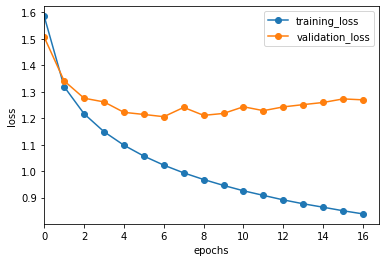

In [12]:
plt.plot(history.epoch, history.history['loss'],'-o',label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o',label='validation_loss')
plt.legend() 
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show() 

In [ ]:
x_test = [os.path.join('./storage/test_files/test/',file) for file in os.listdir('./storage/test_files/test/')] 
x_test.sort()
out = [] 
for file in tqdm(x_test): 
    sample, sample_rate = librosa.load(file) 
    freqs, times, spectrogram = log_specgram(sample, sample_rate) 
    mean = np.mean(spectrogram, axis=0) 
    std = np.std(spectrogram, axis = 0)
    spectrogram = (spectrogram - mean)/std  
    spectrogram = spectrogram.reshape((spectrogram.shape[0],spectrogram.shape[1],1)) 
    out.append(spectrogram)

 89%|████████▉ | 8892/10000 [05:04<00:38, 28.60it/s]

In [19]:
out = np.asarray(out)
out.shape

(10000, 98, 221, 1)

In [14]:
best_model = load_model('./storage/cnn_model_augmented/epoch_007_val_1.206.h5',compile=False)
best_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 98, 221, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 221, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 221, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 221, 32)  9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
add_1 (Add

In [15]:
best_model.compile(loss=tf.keras.losses.KLDivergence(), optimizer='adam')

In [20]:
y_pred = best_model.predict(out)
submission = pd.read_csv('./storage/submission.csv',index_col=0)
submission.loc[:,:] = y_pred 
submission.head()

,bed,bird,cat,dog,down,eight,five,four,go,happy,...,sheila,six,stop,three,tree,two,up,wow,yes,zero
id,,,,,,,,,,,,,,,,,,,,,
0,0.010107,0.000804,0.000181,0.000784,0.019117,0.273678,0.000241,0.009575,0.021891,0.000631,...,0.004374,0.001475,0.000381,0.117688,9.266782e-02,0.067794,0.001654,0.011425,0.000093,0.289810
1,0.013202,0.002525,0.000179,0.000028,0.000059,0.001542,0.015679,0.001082,0.000666,0.004037,...,0.003698,0.051553,0.000551,0.016925,2.004952e-01,0.149615,0.064215,0.000058,0.000502,0.021857
2,0.009404,0.005459,0.000109,0.001863,0.001490,0.003802,0.004208,0.000139,0.045382,0.003444,...,0.003199,0.152729,0.349702,0.004177,5.646699e-04,0.144045,0.019445,0.000072,0.068699,0.015118
3,0.007604,0.000786,0.000196,0.000137,0.000598,0.002164,0.158001,0.355563,0.001797,0.002413,...,0.008582,0.001927,0.000478,0.047959,2.530133e-01,0.045576,0.001392,0.001597,0.000769,0.002618
4,0.009465,0.011006,0.000717,0.022846,0.085229,0.000177,0.021614,0.003737,0.007739,0.005233,...,0.000048,0.004187,0.005472,0.000456,6.961866e-07,0.000820,0.007682,0.011228,0.012172,0.003139


In [21]:
# save output 
submission.to_csv('./storage/spectrogram_cnn_augmented.csv')